# Polars vs Pandas

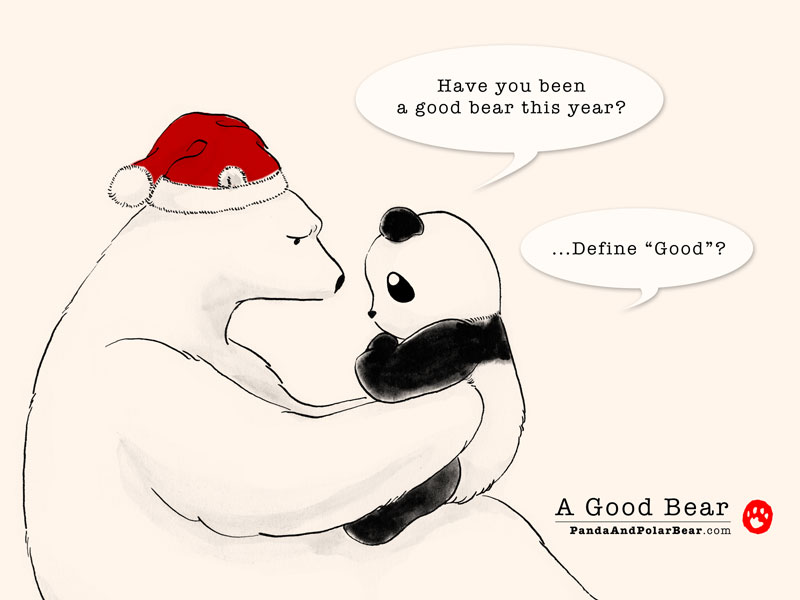

(Didn't know this was a thing before I googled "Panda vs Polar" accidently, Credits: [Panda & Polar Bear](https://www.pandaandpolarbear.com/))

## Polars

* [Python Docs](https://pola-rs.github.io/polars-book/user-guide/introduction.html)
* [Github](https://github.com/pola-rs/polars)
* [PyPI](https://pypi.org/project/polars/)
* Features:
    * Leazy & Eager computation
    * Rust implementation
    * Arrow Memory Format
    * Easy and transparent parallelisation using multithreading
    * PySpark-like Syntax and thus heavily inspired by SQL
    * Supports real NA values in contrast to Pandas
    * Easily deal with complex data types, e.g. list of strings/floats
    * Copy-On-Write (COW) symantics in constrast to Pandas where you kind of never know

# Pandas

* [Docs](https://pandas.pydata.org/)
* [Github](https://github.com/pandas-dev/pandas)
* [PyPI](https://pypi.org/project/pandas/)
* Features:
    * De facto standard data wrangling library for Python
    * Multi-index for rows and columns
    * Quite unrestricted in what's possible, e.g. everything hashable can be a column name like integers, floats, enums
    * Tons of functionality
    * No parallelization
    * Built on top of Numpy
    

# Other Contenders

* [Vaex](https://github.com/vaexio/vaex): Lazy Out-of-Core dataframes
* [Dask](https://docs.dask.org/en/latest/dataframe.html): Built on top of Pandas and parallizes it
* [H2O Datatable](https://github.com/h2oai/datatable): Inspired by R's data.tables
* [Modin](https://modin.readthedocs.io/en/latest/): Uses [Ray](https://docs.ray.io/) or Dask to parallelize Pandas
* [RAPIDS](https://rapids.ai/): Data analysis on GPU

Performance [benchmark](https://h2oai.github.io/db-benchmark/) of various frameworks

# Prelude

In [1]:
from datetime import datetime

import numpy as np
import polars as pl
from pathlib import Path
from polars import col, lit
import pandas as pd
from pandas.io.common import get_handle

In [2]:
pl.__version__

'0.7.16'

In [3]:
pd.__version__

'1.2.4'

In [4]:
# Download a huge csv as a test. Takes a while and only needed once...
big_csv = Path("./big.csv")
csv_url = "http://sdm.lbl.gov/fastbit/data/star2002-full.csv.gz"

if not big_csv.exists():
    with get_handle(csv_url, compression="gzip", mode="r") as fh_in, open(big_csv, "bw") as fh_out:
        fh_out.write(fh_in.handle.buffer.read())

## Eager Execution

In [5]:
edf = pl.read_csv(str(big_csv), has_headers=False)

In [6]:
edf.filter(col("column_1") == 1).select(["column_9"]).head()

shape: (5, 1)
╭──────────╮
│ column_9 │
│ ---      │
│ i64      │
╞══════════╡
│ 654      │
├╌╌╌╌╌╌╌╌╌╌┤
│ 61       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 7        │
├╌╌╌╌╌╌╌╌╌╌┤
│ 27       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 1        │
╰──────────╯

#### alternatively *Pandas* style (not recommended!)

In [7]:
edf[edf["column_1"] == 1][["column_9"]].head()

shape: (5, 1)
╭──────────╮
│ column_9 │
│ ---      │
│ i64      │
╞══════════╡
│ 654      │
├╌╌╌╌╌╌╌╌╌╌┤
│ 61       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 7        │
├╌╌╌╌╌╌╌╌╌╌┤
│ 27       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 1        │
╰──────────╯

Why shouldn't I use the Pandas style? Because ...

* it's much harder to read since it's not *operator chaining*,
* it's more verbose if you assign actual variable names to your dataframes and not just use `df` all the time. Check out this filtering example: `agg_metric_df[agg_metric_df["metric_1"] < 0.9]`. Using `col` to refer to the column of the current dataframe is much cleaner,
* it's not possible to switch later from eager to lazy execution

## Lazy Execution

Just switching `read_csv` to `scan_csv` is all it needs to go from eager to lazy in this example. `collect` or `fetch` is then used to trigger the execution.

In [8]:
ldf = pl.scan_csv(str(big_csv), has_headers=False)

In [9]:
ldf = ldf.filter(col("column_1") == 1)
ldf.select(["column_9"]).collect().head()

shape: (5, 1)
╭──────────╮
│ column_9 │
│ ---      │
│ i64      │
╞══════════╡
│ 654      │
├╌╌╌╌╌╌╌╌╌╌┤
│ 61       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 7        │
├╌╌╌╌╌╌╌╌╌╌┤
│ 27       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 1        │
╰──────────╯

Pandas style fails in lazy mode:

In [10]:
ldf = pl.scan_csv(str(big_csv), has_headers=False)
ldf[ldf["column_1"] == 1][["column_9"]].head()

TypeError: 'LazyFrame' object is not subscriptable

## Slicing & Indexing

In [11]:
edf[1,3] # index by (row, column)

20011015.222604

In [12]:
edf[1, [3]]  # index by (column, row) # a bug right now

Series: 'column_2' [i64]
[
	1613423
]

This works more or less like `iloc` in Pandas:

In [13]:
pdf = pd.read_csv(big_csv, header=None)

In [14]:
pdf.iloc[1, 3]

20011015.222604

In [15]:
pdf.iloc[1, [3]]

3    2.001102e+07
Name: 1, dtype: float64

## Dealing with missing values

In [16]:
left_df = pl.DataFrame({"a": [1, 2, 3], "b": [None, "b", "c"]})
right_df = pl.DataFrame({"a": [1, 2], "c": [42, 69]})

df = left_df.join(right_df, on="a", how="left")
df

shape: (3, 3)
╭─────┬──────┬──────╮
│ a   ┆ b    ┆ c    │
│ --- ┆ ---  ┆ ---  │
│ i64 ┆ str  ┆ i64  │
╞═════╪══════╪══════╡
│ 1   ┆ null ┆ 42   │
├╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 2   ┆ "b"  ┆ 69   │
├╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 3   ┆ "c"  ┆ null │
╰─────┴──────┴──────╯

Note that the last element of the `c` column is `null`, not `NaN` as in Pandas, and the datatype is still int and not automatically converted to float as in Pandas.

In [17]:
df.filter(col("c").is_null())

shape: (1, 3)
╭─────┬─────┬──────╮
│ a   ┆ b   ┆ c    │
│ --- ┆ --- ┆ ---  │
│ i64 ┆ str ┆ i64  │
╞═════╪═════╪══════╡
│ 3   ┆ "c" ┆ null │
╰─────┴─────┴──────╯

Pandas does something pretty scary here

In [18]:
left_pdf = left_df.to_pandas()
right_pdf = right_df.to_pandas()

Note that "c"-column has type int:

In [19]:
right_pdf.dtypes

a    int64
c    int64
dtype: object

In [20]:
pdf = pd.merge(left_pdf, right_pdf, on="a", how="left")

In [21]:
pdf

a     b     c
0  1  None  42.0
1  2     b  69.0
2  3     c   NaN

Depending on the datatype, Pandas shows `None` or `NaN`, also note that the column `c` was converted from `int` to `float` without our consent!

# New columns

In [22]:
df.with_column((lit(3)*col("c")).alias("3*c"))

shape: (3, 4)
╭─────┬──────┬──────┬──────╮
│ a   ┆ b    ┆ c    ┆ 3*c  │
│ --- ┆ ---  ┆ ---  ┆ ---  │
│ i64 ┆ str  ┆ i64  ┆ i64  │
╞═════╪══════╪══════╪══════╡
│ 1   ┆ null ┆ 42   ┆ 126  │
├╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 2   ┆ "b"  ┆ 69   ┆ 207  │
├╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 3   ┆ "c"  ┆ null ┆ null │
╰─────┴──────┴──────┴──────╯

Same is possible in Pandas but note that we have to retype again the variable name `pdf` just to access a column!

In [23]:
pdf.assign(**{"3*c": 3*pdf["c"]})

a     b     c    3*c
0  1  None  42.0  126.0
1  2     b  69.0  207.0
2  3     c   NaN    NaN

# Column Expressions

In [24]:
df = pl.DataFrame(
    {
        "nrs": [1, 2, 3, None, 5],
        "names": ["foo", "ham", "spam", "egg", None],
        "random": np.random.rand(5),
        "groups": ["A", "A", "B", "C", "B"],
    }
)
df

shape: (5, 4)
╭──────┬────────┬────────┬────────╮
│ nrs  ┆ names  ┆ random ┆ groups │
│ ---  ┆ ---    ┆ ---    ┆ ---    │
│ i64  ┆ str    ┆ f64    ┆ str    │
╞══════╪════════╪════════╪════════╡
│ 1    ┆ "foo"  ┆ 0.142  ┆ "A"    │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ 2    ┆ "ham"  ┆ 0.201  ┆ "A"    │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ 3    ┆ "spam" ┆ 0.495  ┆ "B"    │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ null ┆ "egg"  ┆ 0.142  ┆ "C"    │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┤
│ 5    ┆ null   ┆ 0.798  ┆ "B"    │
╰──────┴────────┴────────┴────────╯

In [25]:
# and in Pandas
pdf = df.to_pandas()

#### Construct a new dataframe with a sorted column and some aggregations

In [26]:
df.select(
    [
        pl.sum("nrs"), # or equivalently col("nrs").sum()
        col("names").sort(),
        col("names").n_unique().alias("unique_names_1"),
    ]
)

shape: (5, 3)
╭─────┬────────┬────────────────╮
│ nrs ┆ names  ┆ unique_names_1 │
│ --- ┆ ---    ┆ ---            │
│ i64 ┆ str    ┆ u32            │
╞═════╪════════╪════════════════╡
│ 11  ┆ null   ┆ 5              │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 11  ┆ "egg"  ┆ 5              │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 11  ┆ "foo"  ┆ 5              │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 11  ┆ "ham"  ┆ 5              │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 11  ┆ "spam" ┆ 5              │
╰─────┴────────┴────────────────╯

In Pandas we create a new DataFrame and reference several times `pdf`

In [27]:
pd.DataFrame(
    {
        "nrs": pdf["nrs"].sum(),
        "names": pdf["names"].sort_values(),
        "unique_names_1": pdf["names"].nunique(dropna=False),
    }
)

nrs names  unique_names_1
3  11.0   egg               5
0  11.0   foo               5
1  11.0   ham               5
2  11.0  spam               5
4  11.0  None               5

#### Select certain elements from a column by filtering from another

In [28]:
df.select(col("names").filter(col("random") > 0.4))

shape: (2, 1)
╭────────╮
│ names  │
│ ---    │
│ str    │
╞════════╡
│ "spam" │
├╌╌╌╌╌╌╌╌┤
│ null   │
╰────────╯

Syntax in Pandas is way less readable

In [29]:
pdf.loc[pdf["random"] > 0.4][["names"]]

names
2  spam
4  None

### Complex expressions are also possible

All expressions in Polars are *embarassingly parallel* by design and thus automatically parallelized

In [30]:
df.select(
    [
        (pl.sum("nrs") * pl.when(col("random") > 0.5)
                           .then(0)
                           .otherwise(col("random"))
        ).alias("result")
    ]
)

shape: (5, 1)
╭────────╮
│ result │
│ ---    │
│ f64    │
╞════════╡
│ 1.567  │
├╌╌╌╌╌╌╌╌┤
│ 2.212  │
├╌╌╌╌╌╌╌╌┤
│ 5.448  │
├╌╌╌╌╌╌╌╌┤
│ 1.559  │
├╌╌╌╌╌╌╌╌┤
│ 0.0    │
╰────────╯

SQL-like `when`/`then`/`otherwise` statements are not possible in Pandas, thus we have to use `np.where`:

In [31]:
pd.Series(
    np.where(pdf["random"] > 0.5, 0, pdf["random"] * pdf["nrs"].sum()), name="result"
).to_frame()

result
0  1.566777
1  2.211681
2  5.448417
3  1.558743
4  0.000000

#### Even window expressions are possible

In [32]:
df.select(
    [
        col("*"),  # select all
        col("random").sum().over("groups").alias("sum[random]/groups"),
        col("random").list().over("names").alias("random/name"),
    ]
)

shape: (5, 6)
╭──────┬────────┬────────┬────────┬────────────────────┬─────────────────────────╮
│ nrs  ┆ names  ┆ random ┆ groups ┆ sum[random]/groups ┆ random/name             │
│ ---  ┆ ---    ┆ ---    ┆ ---    ┆ ---                ┆ ---                     │
│ i64  ┆ str    ┆ f64    ┆ str    ┆ f64                ┆ list [f64]              │
╞══════╪════════╪════════╪════════╪════════════════════╪═════════════════════════╡
│ 1    ┆ "foo"  ┆ 0.142  ┆ "A"    ┆ 0.343              ┆ "[0.14243428535992486]" │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2    ┆ "ham"  ┆ 0.201  ┆ "A"    ┆ 0.343              ┆ "[0.2010619267250574]"  │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 3    ┆ "spam" ┆ 0.495  ┆ "B"    ┆ 1.293              ┆ "[0.4953106731935223]"  │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ null ┆ "egg"  ┆ 0.142  ┆ "C"    ┆ 0.142              ┆ "[0.14170388379842103]" │
├╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 5    ┆ null   ┆ 0.798  ┆ "B"    ┆ 1.293              ┆ "[0.7975366760867535]"  │
╰──────┴────────┴────────┴────────┴────────────────────┴─────────────────────────╯

Doing the same in Pandas is a bit more complex. Also note that there is an unexpected `NaN` in the last row. This is due to the fact that when inserting `pdf.groupby(['names'], dropna=False)['random'].apply(list)` we compare `NaN` to `NaN` which is false by definition. This is just another subtle problem caused by the fact that Pandas uses `NaN` to express `NA`.
Also note that Polars needs no explicit index like Pandas to do operations like this, just like Spark has no way to set an index explicitely.

In [33]:
(pdf.set_index("groups")
    .assign(**{"sum[random]/groups": pdf.groupby(['groups'])['random'].sum()})
    .set_index("names")
    .assign(**{"random/name": pdf.groupby(['names'], dropna=False)['random'].apply(list)})
    .reset_index()
)

names  nrs    random  sum[random]/groups            random/name
0   foo  1.0  0.142434            0.343496  [0.14243428535992486]
1   ham  2.0  0.201062            0.343496   [0.2010619267250574]
2  spam  3.0  0.495311            1.292847   [0.4953106731935223]
3   egg  NaN  0.141704            0.141704  [0.14170388379842103]
4  None  5.0  0.797537            1.292847                    NaN

# GroupBy

In [34]:
df = pl.read_csv("https://theunitedstates.io/congress-legislators/legislators-current.csv")
pdf = df.to_pandas()

In [35]:
(df.lazy()  # allows for working only on a subset using limit
   .groupby("first_name")
   .agg(
       [
           col("party").count().alias("n_party"),  # renaming an aggregated column is a bliss
           col("gender").list(),
           col("last_name").first(),
       ]
   )
   .sort("n_party", reverse=True)
   .limit(5)
   .collect()
)

shape: (5, 4)
╭────────────┬─────────┬─────────────────┬─────────────────╮
│ first_name ┆ n_party ┆ gender_agg_list ┆ last_name_first │
│ ---        ┆ ---     ┆ ---             ┆ ---             │
│ str        ┆ u32     ┆ list [str]      ┆ str             │
╞════════════╪═════════╪═════════════════╪═════════════════╡
│ "John"     ┆ 19      ┆ "[M, M, ... M]" ┆ "Barrasso"      │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ "Mike"     ┆ 12      ┆ "[M, M, ... M]" ┆ "Kelly"         │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ "Michael"  ┆ 11      ┆ "[M, M, ... M]" ┆ "Bennet"        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ "David"    ┆ 11      ┆ "[M, M, ... M]" ┆ "Cicilline"     │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ "James"    ┆ 9       ┆ "[M, M, ... M]" ┆ "Inhofe"        │
╰────────────┴─────────┴─────────────────┴─────────────────╯

Note how easily we can deal with lists of strings by aggregating over gender using `list()`.

In Pandas the same operation feels more like string hacking and renaming happens as a separate step having unnecessary repetitions of the column names. Everything is of course eagerly evaluated.

In [36]:
(pdf.groupby("first_name")
    .agg({"party": "count", 
          "gender": lambda grp: grp.to_list(), 
          "last_name": "first"})
    .rename(columns={"party": "n_party", 
                     "gender": "gender_agg_list", 
                     "last_name": "last_name_first"})
    .sort_values(by="n_party", ascending=False)
    .reset_index()
    .head(5))

first_name  n_party                                    gender_agg_list  \
0       John       19  [M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...   
1       Mike       12               [M, M, M, M, M, M, M, M, M, M, M, M]   
2    Michael       11                  [M, M, M, M, M, M, M, M, M, M, M]   
3      David       11                  [M, M, M, M, M, M, M, M, M, M, M]   
4      James        9                        [M, M, M, M, M, M, M, M, M]   

  last_name_first  
0        Barrasso  
1           Kelly  
2          Bennet  
3       Cicilline  
4          Inhofe

#### Conditionals in aggregations

In [37]:
(df.lazy()
   .groupby("state")
   .agg(
       [
           (col("party") == "Democrat").sum().alias("demo"),
           (col("party") == "Republican").sum().alias("rep"),
       ]
   )
   .sort("demo", reverse=True)
   .limit(5)
   .collect()
)

shape: (5, 3)
╭───────┬──────┬─────╮
│ state ┆ demo ┆ rep │
│ ---   ┆ ---  ┆ --- │
│ str   ┆ u32  ┆ u32 │
╞═══════╪══════╪═════╡
│ "CA"  ┆ 44   ┆ 11  │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌┤
│ "NY"  ┆ 21   ┆ 8   │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌┤
│ "IL"  ┆ 15   ┆ 5   │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌┤
│ "TX"  ┆ 13   ┆ 24  │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌┤
│ "NJ"  ┆ 12   ┆ 2   │
╰───────┴──────┴─────╯

The translation to Pandas is "somewhat" more complicated... kudos to everyone able to solve this without looking it up on StackOverflow :-) 

In [38]:
(pdf.groupby("state")
    .agg({"party": [("demo", lambda grp: np.sum(grp == "Democrat")), 
                    ("rep", lambda grp:  np.sum(grp == "Republican"))]})
    .droplevel(0, axis=1) 
    .reset_index()
    .sort_values(by="demo", ascending=False)
    .head(5)
)

state  demo  rep
5     CA    44   11
37    NY    21    8
16    IL    15    5
47    TX    13   24
34    NJ    12    2

#### Composition and reuse of more complex operations

In [39]:
def compute_age() -> pl.Expr:
    # Date64 is time in ms
    ms_to_year = 1e3 * 3600 * 24 * 365
    return (
        lit(datetime(2021, 1, 1)) - col("birthday")
    ) / (ms_to_year)


def avg_age(gender: str) -> pl.Expr:
    return (
        compute_age()
        .filter(col("gender") == gender)
        .mean()
        .alias(f"avg {gender} age")
    )


(df.lazy()
   .groupby(["state"])
   .agg(
       [
            avg_age("M"),
            avg_age("F"),
       ]
   )
   .sort("state")
   .limit(5)
   .collect()
)

shape: (5, 3)
╭───────┬───────────┬───────────╮
│ state ┆ avg M age ┆ avg F age │
│ ---   ┆ ---       ┆ ---       │
│ str   ┆ f64       ┆ f64       │
╞═══════╪═══════════╪═══════════╡
│ "AK"  ┆ 71.899    ┆ 63.657    │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ "AL"  ┆ 65.167    ┆ 56.038    │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ "AR"  ┆ 58.325    ┆ NaN       │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ "AS"  ┆ NaN       ┆ 73.06     │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ "AZ"  ┆ 60.004    ┆ 59.168    │
╰───────┴───────────┴───────────╯

Translating this to Pandas is really hard since we have no way to refer to a column. Also with Pandas' `agg` we have only access to the aggregation column and cannot filter by another, thus we have to use `apply`.

In [40]:
def p_compute_age(grp: pd.DataFrame):
    # Date64 is time in ms
    s_to_year = 3600 * 24 * 365
    return (
        (datetime(2021, 1, 1) - grp["birthday"]).dt.total_seconds()
    ) / (s_to_year)


def p_avg_age(grp: pd.DataFrame, gender: str):
    age = p_compute_age(grp)
    mean_age = age[grp["gender"] == gender].mean()
    return pd.Series([mean_age], index=[f"avg {gender} age"])


(pdf.groupby("state")
    .apply(
        lambda grp: pd.concat(
            [p_avg_age(grp, gender="M"),
             p_avg_age(grp, gender="F")]
        )
    )
    .reset_index()
    .sort_values(by="state")
    .head(5)
)

state  avg M age  avg F age
0    AK  71.898630  63.657534
1    AL  65.167466  56.038356
2    AR  58.324658        NaN
3    AS        NaN  73.060274
4    AZ  60.003767  59.168037

The same code in Pandas just feels not as clean as in Polars, thus showing nicely the power that comes with Polars' composable expressions.

# User-Defined (Aggregation) Functions

In [41]:
df = pl.DataFrame({"foo": np.arange(10), 
                   "bar": np.random.rand(10), 
                   "cls": np.random.randint(2, size=10)})
pdf = df.to_pandas()

In [42]:
df

shape: (10, 3)
╭─────┬───────┬─────╮
│ foo ┆ bar   ┆ cls │
│ --- ┆ ---   ┆ --- │
│ i64 ┆ f64   ┆ i64 │
╞═════╪═══════╪═════╡
│ 0   ┆ 0.221 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 1   ┆ 0.837 ┆ 0   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 2   ┆ 0.297 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 3   ┆ 0.296 ┆ 0   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ ... ┆ ...   ┆ ... │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 5   ┆ 0.105 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 6   ┆ 0.045 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 7   ┆ 0.002 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 8   ┆ 0.523 ┆ 0   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 9   ┆ 0.872 ┆ 1   │
╰─────┴───────┴─────╯

#### Vector Operations

Use `map` for vector operations on a whole column, i.e. series -> series:

In [43]:
def my_custom_func(s: pl.Series) -> pl.Series:
    return np.exp(s) / np.log(s)

# this udf is no longer needed in future polars versions
my_udf = pl.udf(my_custom_func, output_type=pl.Float64)

In [44]:
df.filter(col("bar").map(my_udf) > -1)

shape: (4, 3)
╭─────┬───────┬─────╮
│ foo ┆ bar   ┆ cls │
│ --- ┆ ---   ┆ --- │
│ i64 ┆ f64   ┆ i64 │
╞═════╪═══════╪═════╡
│ 0   ┆ 0.221 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 5   ┆ 0.105 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 6   ┆ 0.045 ┆ 1   │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┤
│ 7   ┆ 0.002 ┆ 1   │
╰─────┴───────┴─────╯

Use `apply` for scalar operations on a cell or group level but returning a scalar:

In [45]:
df.select(col("bar").apply(lambda x: 3*x))

shape: (10, 1)
╭───────╮
│ bar   │
│ ---   │
│ f64   │
╞═══════╡
│ 0.664 │
├╌╌╌╌╌╌╌┤
│ 2.512 │
├╌╌╌╌╌╌╌┤
│ 0.891 │
├╌╌╌╌╌╌╌┤
│ 0.887 │
├╌╌╌╌╌╌╌┤
│ ...   │
├╌╌╌╌╌╌╌┤
│ 0.316 │
├╌╌╌╌╌╌╌┤
│ 0.134 │
├╌╌╌╌╌╌╌┤
│ 0.007 │
├╌╌╌╌╌╌╌┤
│ 1.568 │
├╌╌╌╌╌╌╌┤
│ 2.615 │
╰───────╯

In Pandas, you have `apply` and `applymap` working quite similarily:

In [46]:
pdf[pdf["bar"].apply(my_custom_func) > -1]

foo       bar  cls
0    0  0.221317    1
5    5  0.105456    1
6    6  0.044635    1
7    7  0.002450    1

In [47]:
pdf[["bar"]].applymap(lambda x: 3*x)

bar
0  0.663950
1  2.511606
2  0.890784
3  0.887259
4  0.979404
5  0.316369
6  0.133905
7  0.007349
8  1.567505
9  2.615481

#### Aggregation Operations

In [48]:
df.groupby(["cls"]).agg([col("bar").apply(lambda grp: 3*grp.sum())])

shape: (2, 2)
╭─────┬───────╮
│ cls ┆ bar   │
│ --- ┆ ---   │
│ i64 ┆ f64   │
╞═════╪═══════╡
│ 0   ┆ 4.966 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 1   ┆ 5.607 │
╰─────┴───────╯

Quite anagously in Pandas but of course you need to fight the multi-index

In [49]:
pdf.groupby("cls", as_index=False).agg({"bar": lambda grp: 3 * grp.sum()})

cls       bar
0    0  4.966370
1    1  5.607243